# 🏀 Player Position Classification using Machine Learning

## Introduction

In this project, we apply machine learning techniques to classify basketball players into their respective positions — Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C) — based on their performance statistics.

We work with two datasets: season statistics and player information. After cleaning and merging the data, we build and evaluate multiple classification models (Random Forest, Gradient Boosting, AdaBoost, and XGBoost) to compare their performance.

The objective is to perform a **multi-class classification task** and analyze the most relevant features for each position, ensuring a fair and balanced approach throughout the process.


## 🔗 Data Access: Importing Files from Google Drive

To ensure reproducibility and remote access, we load both datasets directly from Google Drive using the PyDrive library. This step includes:

- Installing and importing the required PyDrive modules
- Authenticating access to the user's Google Drive account
- Downloading the `seasons_stats.csv` and `player_data.csv` files using their unique file IDs

These files contain the core player statistics and player metadata needed for the analysis and classification tasks.


In [25]:
!pip install -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id_seasons = "1Oki20rTt2MCo9YkPY4J_czbbpFbPNMFb"
downloaded_seasons = drive.CreateFile({'id': file_id_seasons})
downloaded_seasons.GetContentFile('seasons_stats.csv')

file_id_players = "1IZX_F2sbij5V4cALgYsuq7cEg_wSNnS2"
downloaded_players = drive.CreateFile({'id': file_id_players})
downloaded_players.GetContentFile('player_data.csv')




## 📥 Loading the Datasets

After downloading the files from Google Drive, we load them into pandas DataFrames:

- `player_data.csv`: Contains personal and general information about each player (e.g., position, height, weight, college).
- `seasons_stats.csv`: Contains performance statistics for each player per season.

We ensure the correct encoding is applied (`utf-8` and `latin1`) to avoid character-related errors during loading.

This step is essential to verify that the datasets were successfully loaded and to inspect their structure.


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

players = pd.read_csv('player_data.csv', encoding='utf-8')
seasons = pd.read_csv('seasons_stats.csv', encoding='latin1')

print(players.columns.tolist())


['Player', 'From', 'To', 'Pos', 'Ht', 'Wt', 'Birth Date', 'Colleges']


## 🔄 Merging and Preparing the Dataset

We prepare the dataset by merging relevant columns from `player_data` into `seasons_stats`, using the `Player` column as a common key.

Steps:
- Selected only relevant columns from `player_data` (`Player`, `Pos`, `Ht`, `Wt`) and renamed them for clarity (`Ht` → `Height`, `Wt` → `Weight`).
- Merged this subset with the `seasons_stats` DataFrame using a left join on the `Player` column.
- Verified the result by checking the shape and a sample of the merged dataset.
- Cleaned up redundant columns (`Pos_y`) and finalized the correct position field as `Pos`.

This step ensures that all relevant player metadata is integrated with season statistics for subsequent analysis.


In [27]:
pl = players[['Player', 'Pos', 'Ht', 'Wt']].rename(
    columns={'Ht':'Height', 'Wt':'Weight'}
)

df = seasons.merge(
    pl,
    on='Player',
    how='left'
)

print(df.shape)
print(df[['Player','Pos_x','Pos_y','Height','Weight']].head())

df = df.rename(columns={'Pos_x':'Pos'}).drop(columns=['Pos_y'])


(29179, 54)
            Player Pos_x Pos_y Height  Weight
0  Curly Armstrong   G-F   G-F   5-11   170.0
1     Cliff Barker    SG     G    6-2   185.0
2    Leo Barnhorst    SF   F-G    6-4   190.0
3       Ed Bartels     F     F    6-5   195.0
4       Ed Bartels     F     F    6-5   195.0


##  Merging and Cleaning Duplicates

Before merging the datasets, we clean the `player_data` DataFrame to ensure each player appears only once. Specifically:

- We select relevant columns (`Player`, `Pos`, `Ht`, `Wt`) and remove duplicates based on the `Player` field.
- We rename the height and weight columns to standard names (`Height`, `Weight`) for clarity.
- We perform a left merge with the `seasons_stats` DataFrame using the `Player` column as the key.

After merging, we verify:
- That the number of rows in `df` remains consistent with `seasons_stats`, ensuring no rows were lost.
- That some values for `Height` and `Weight` are missing (`NaN`), which we account for in further preprocessing.

This step ensures a consistent and clean base for building the classification model.


In [30]:
pl = (
    players[['Player','Pos','Ht','Wt']]
    .drop_duplicates(subset=['Player'])     # <-- eliminamos filas repetidas de Player
    .rename(columns={'Ht':'Height','Wt':'Weight'})
)

df = seasons.merge(
    pl,
    on='Player',
    how='left'
)

print("Rows en seasons_stats:", seasons.shape[0])
print("Rows en df después del merge:", df.shape[0])


print(df[['Height','Weight']].isna().sum())



Rows en seasons_stats: 28057
Rows en df después del merge: 28057
Height    2209
Weight    2212
dtype: int64


## Data Cleaning: Height and Weight Columns

To ensure our dataset is clean and ready for modeling, several important steps were taken regarding the `Height` and `Weight` variables:

### 1. Height Conversion
Some height values are recorded in the format `"feet-inches"` (e.g. `"6-5"`). To convert them into a single numeric value (in inches), a helper function `height_to_inches` was applied to transform strings like `"6-5"` into `77`.

Additionally, we used `pd.to_numeric` with the parameter `errors='coerce'` to ensure all height values are stored as numeric types, converting any invalid entries to `NaN`.

### 2. Column Name Consistency
We made sure that the column `Pos` exists before imputing missing values. If `Pos` was named differently after merging (`Pos_x` or `Pos_y`), we renamed it back to `Pos`.

### 3. Removing Useless Columns
Redundant columns like `Pos_x` and `Pos_y` (if still present) were dropped to prevent duplication.

### 4. Imputing Missing Values by Position
Missing values in `Height` and `Weight` were filled using the median of each position group (e.g., centers, guards). This way, the imputation is more contextually accurate based on typical physical characteristics of each position.

```python
df['Height'] = df.groupby('Pos')['Height'].transform(lambda x: x.fillna(x.median()))
df['Weight'] = df.groupby('Pos')['Weight'].transform(lambda x: x.fillna(x.median()))


In [31]:
df = df.rename(columns={'Pos_x':'Pos'}).drop(columns=['Pos_y'])

print('Columnas de df:', df.columns.tolist())


Columnas de df: ['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Height', 'Weight']


In [32]:
def height_to_inches(h):
    if isinstance(h, str) and '-' in h:
        feet, inches = h.split('-')
        return int(feet) * 12 + int(inches)
    return h  # ya es numérico

df['Height'] = df['Height'].apply(height_to_inches)

df['Height'] = pd.to_numeric(df['Height'], errors='coerce')


In [33]:
if 'Pos' not in df.columns:
    if 'Pos_x' in df.columns:
        df.rename(columns={'Pos_x': 'Pos'}, inplace=True)
    elif 'Pos_y' in df.columns:
        df.rename(columns={'Pos_y': 'Pos'}, inplace=True)

for col in ['Pos_x', 'Pos_y']:
    if col in df.columns and col != 'Pos':
        df.drop(columns=[col], inplace=True)

df['Height'] = df.groupby('Pos')['Height'].transform(lambda x: x.fillna(x.median()))
df['Weight'] = df.groupby('Pos')['Weight'].transform(lambda x: x.fillna(x.median()))

print(df[['Height', 'Weight']].isna().sum())


Height    0
Weight    0
dtype: int64


## Data Cleaning and Preprocessing

This block performs essential data preparation steps before model training:

1. **Remove duplicate rows**: Ensures data quality by removing exact duplicate entries.
2. **Encode target variable**: The categorical variable `Pos` (player position) is encoded into numerical labels using `LabelEncoder`, creating the `Pos_label` column.
3. **Feature scaling**: All numerical columns are standardized using `StandardScaler` to have mean 0 and standard deviation 1. This is especially useful for algorithms sensitive to feature scale.
4. **Output**: The shape of the DataFrame and the label mapping between position names and their corresponding integer codes are printed for reference.

---

## Position Simplification and Reprocessing

This section refines the `Pos` (Position) variable to reduce complexity:

1. **Simplify composite positions**: For players with multiple roles (e.g., `"SG-SF"`), only the first listed position is retained (e.g., `"SG"`).
2. **Repeat data cleaning steps**: After simplification, duplicates are removed again, positions are re-encoded, and numerical features are re-scaled.
3. **Output**: The updated DataFrame shape and the simplified label mapping are displayed.

> This simplification helps reduce the number of target classes, which may improve model performance and reduce confusion between similar positions.


In [34]:
df = df.drop_duplicates()

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
df['Pos_label'] = le.fit_transform(df['Pos'])

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Pos_label')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Filas tras eliminar duplicados:", df.shape[0])
print("Dimensiones finales del DataFrame:", df.shape)
print("Mapeo Pos → Etiqueta:", dict(zip(le.classes_, le.transform(le.classes_))))


Filas tras eliminar duplicados: 28057
Dimensiones finales del DataFrame: (28057, 54)
Mapeo Pos → Etiqueta: {'C': np.int64(0), 'C-F': np.int64(1), 'C-PF': np.int64(2), 'C-SF': np.int64(3), 'F': np.int64(4), 'F-C': np.int64(5), 'F-G': np.int64(6), 'G': np.int64(7), 'G-F': np.int64(8), 'PF': np.int64(9), 'PF-C': np.int64(10), 'PF-SF': np.int64(11), 'PG': np.int64(12), 'PG-SF': np.int64(13), 'PG-SG': np.int64(14), 'SF': np.int64(15), 'SF-C': np.int64(16), 'SF-PF': np.int64(17), 'SF-PG': np.int64(18), 'SF-SG': np.int64(19), 'SG': np.int64(20), 'SG-PF': np.int64(21), 'SG-PG': np.int64(22), 'SG-SF': np.int64(23)}


In [35]:
df['Pos'] = df['Pos'].str.split('-').str[0]

df = df.drop_duplicates()

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
df['Pos_label'] = le.fit_transform(df['Pos'])

num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Pos_label')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Dimensiones tras simplificar y codificar:", df.shape)
print("Mapeo Pos → Etiqueta:", dict(zip(le.classes_, le.transform(le.classes_))))


Dimensiones tras simplificar y codificar: (28057, 54)
Mapeo Pos → Etiqueta: {'C': np.int64(0), 'F': np.int64(1), 'G': np.int64(2), 'PF': np.int64(3), 'PG': np.int64(4), 'SF': np.int64(5), 'SG': np.int64(6)}


##  Position Remapping

- Generalizes some hybrid positions:
  - `'F'` → `'SF'` (Small Forward)
  - `'G'` → `'SG'` (Shooting Guard)

- Removes duplicates again (in case remapping created any).
- Re-encodes `Pos` using `LabelEncoder` and scales numeric features with `StandardScaler`.
- Outputs the new shape and label mapping for verification.

---

##  Class Distribution Plot

- Barplot shows the number of players per position.
- Helps visualize class imbalance, which is important for training fair models.


In [36]:
df['Pos'] = df['Pos'].replace({
    'F': 'SF',   # Mapea genérico Forward a Alero
    'G': 'SG'    # Mapea genérico Guard a Escolta
})

df = df.drop_duplicates()

from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
df['Pos_label'] = le.fit_transform(df['Pos'])

num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('Pos_label')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("Dimensiones tras remapear y codificar:", df.shape)
print("Nuevo mapeo Pos → Etiqueta:", dict(zip(le.classes_, le.transform(le.classes_))))


Dimensiones tras remapear y codificar: (28057, 54)
Nuevo mapeo Pos → Etiqueta: {'C': np.int64(0), 'PF': np.int64(1), 'PG': np.int64(2), 'SF': np.int64(3), 'SG': np.int64(4)}


<ipython-input-37-67b8b41d1553>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Pos', order=df['Pos'].value_counts().index, palette='Set2')


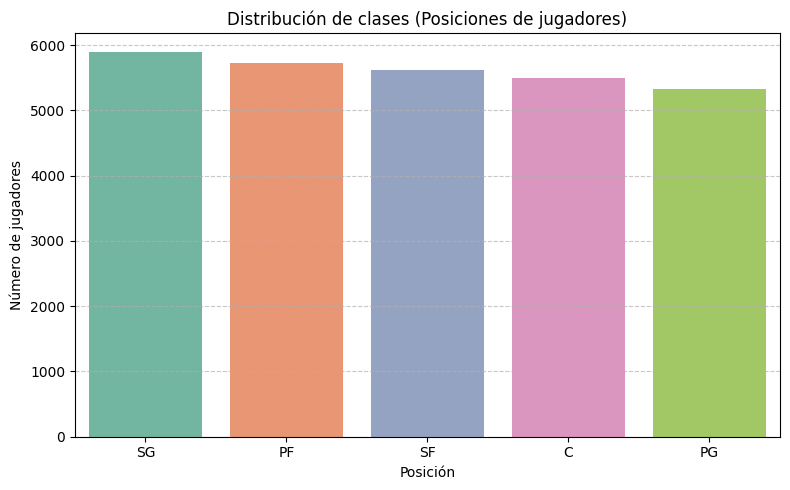

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Pos', order=df['Pos'].value_counts().index, palette='Set2')
plt.title("Distribución de clases (Posiciones de jugadores)")
plt.xlabel("Posición")
plt.ylabel("Número de jugadores")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Model Training and Evaluation (Random Forest)

- **Feature selection**: Only numerical features are used for training.
- **Missing values**: Filled using column-wise mean with `SimpleImputer`.
- **Train-test split**: Performed with stratification to preserve class distribution.
- **Model**: A `RandomForestClassifier` is trained and evaluated.
- **Metrics**:
  - Accuracy is printed.
  - A classification report shows precision, recall, and F1-score per class.
  - Confusion matrix helps visualize misclassifications.

---

## Gradient Boosting Classifier

- A second model using `GradientBoostingClassifier` is trained and used for prediction (`y_pred_g`).
- Evaluation steps for this model likely follow next.

> This section compares tree-based models to classify player positions.


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Pos_label'])
y = df['Pos_label']


imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

y_pred = rf.predict(X_test)
print("Precisión en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))


Precisión en test: 0.8136136849607983

Reporte de clasificación:
               precision    recall  f1-score   support

           C       0.85      0.88      0.87      1098
          PF       0.77      0.75      0.76      1146
          PG       0.88      0.90      0.89      1064
          SF       0.77      0.76      0.76      1125
          SG       0.80      0.80      0.80      1179

    accuracy                           0.81      5612
   macro avg       0.81      0.82      0.81      5612
weighted avg       0.81      0.81      0.81      5612


Matriz de confusión:
 [[965 123   0  10   0]
 [156 855   0 134   1]
 [  2   1 953   4 104]
 [  7 126   3 855 134]
 [  0   5 122 114 938]]


##  Gradient Boosting Evaluation

- Trains a `GradientBoostingClassifier` on the same data.
- Outputs classification metrics (precision, recall, F1-score) per class.
- Allows comparison with previous models (e.g., Random Forest).

-
## XGBoost Classifier

- Creates a clean copy of the dataset for a new experiment.
- Drops categorical and unnecessary columns, keeping only numeric features.
- Encodes the target (`Pos_label`) and splits the data.
- Trains and evaluates an `XGBClassifier` (Extreme Gradient Boosting).
- Displays classification report for performance comparison.

> This section introduces a more advanced boosting model (XGBoost), often outperforming simpler models in structured data tasks.


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1098
           1       0.73      0.71      0.72      1146
           2       0.86      0.87      0.86      1064
           3       0.72      0.70      0.71      1125
           4       0.74      0.75      0.75      1179

    accuracy                           0.78      5612
   macro avg       0.78      0.78      0.78      5612
weighted avg       0.78      0.78      0.78      5612



In [39]:
df_clean = df.copy()

y = df_clean['Pos_label']

object_cols = df_clean.select_dtypes(include='object').columns
df_clean = df_clean.drop(columns=object_cols)

X = df_clean.drop(columns=['Pos_label'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1373
           1       0.77      0.77      0.77      1432
           2       0.88      0.89      0.89      1330
           3       0.78      0.78      0.78      1406
           4       0.80      0.79      0.79      1474

    accuracy                           0.82      7015
   macro avg       0.82      0.82      0.82      7015
weighted avg       0.82      0.82      0.82      7015



##  AdaBoost Classifier

- Drops rows with missing values to ensure clean input for the model.
- Uses `AdaBoostClassifier` with default settings.
- Trains and evaluates performance using a classification report.
- Useful as a lightweight boosting model to compare with XGBoost and Gradient Boosting.



##  Feature Importance (Random Forest)

- Extracts and visualizes feature importances from the Random Forest model.
- Uses a horizontal bar plot (`seaborn`) to show the top 15 most important features.
- Helps interpret which variables most influence position classification.

> This section combines model evaluation with interpretability, highlighting key features used by the model.


In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

df_clean = df_clean.dropna()

X = df_clean.drop(columns=['Pos_label'])
y = df_clean['Pos_label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

print("AdaBoost Results:")
print(classification_report(y_test, y_pred_ada))


AdaBoost Results:
              precision    recall  f1-score   support

           0       0.84      0.52      0.65       610
           1       0.61      0.76      0.67       860
           2       0.82      0.88      0.85      1001
           3       0.66      0.66      0.66       914
           4       0.70      0.66      0.68      1030

    accuracy                           0.71      4415
   macro avg       0.72      0.70      0.70      4415
weighted avg       0.72      0.71      0.71      4415



<ipython-input-41-122688bc6d6d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values[:15], y=feat_importance.index[:15], palette='viridis')


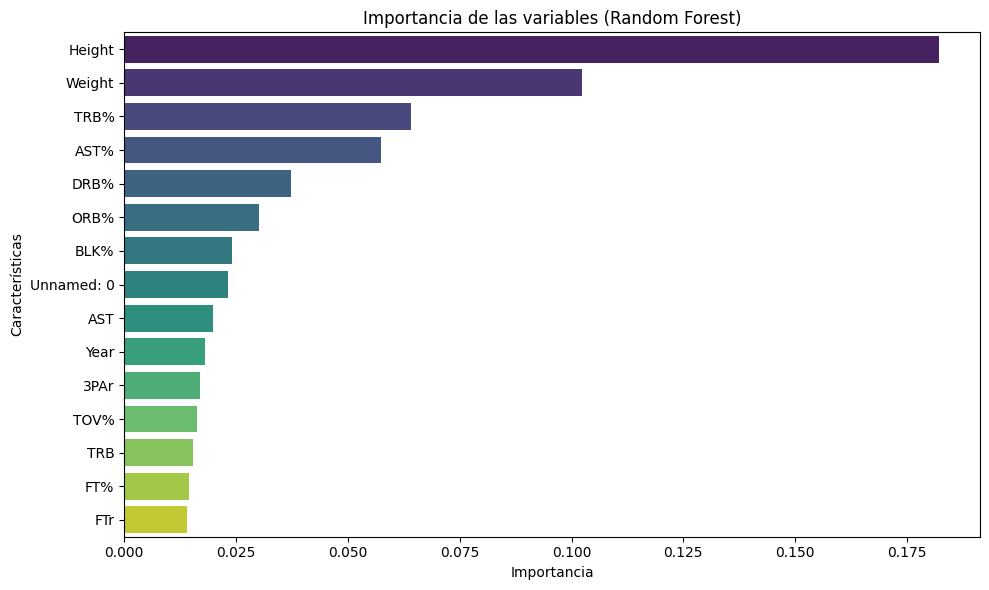

In [41]:
importances = rf.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance.values[:15], y=feat_importance.index[:15], palette='viridis')
plt.title("Importancia de las variables (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


##  Hyperparameter Tuning (Random Forest)

- **Search method**: Uses `RandomizedSearchCV` to find the best combination of hyperparameters for `RandomForestClassifier`.
- **Search space** includes:
  - `n_estimators`: number of trees
  - `max_depth`: depth of each tree
  - `min_samples_split` and `min_samples_leaf`: split thresholds
  - `bootstrap`: whether to use bootstrapping
- **Cross-validation**: 3-fold CV is applied to estimate generalization.


##  Optimized Model Evaluation

- The best model found by `RandomizedSearchCV` is used to predict the test set.
- Final accuracy and classification report are shown.
- Performance is slightly improved compared to default parameters.

> Hyperparameter tuning helps extract the full potential of the model, improving accuracy and class-wise performance.


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Configurar RandomizedSearchCV
rf_base = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=20,              # número de combinaciones a probar
    scoring='accuracy',
    cv=3,                   # validación cruzada 3-folios
    random_state=42,
    n_jobs=-1
)

# Ejecutar búsqueda en el entrenamiento
rand_search.fit(X_train, y_train)

# Tomar el mejor estimador y evaluar
best_rf = rand_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Mejores hiperparámetros:", rand_search.best_params_)
print("Precisión en test (optimizado):", best_rf.score(X_test, y_test))
print("\nReporte de clasificación (optimizado):\n",
      classification_report(y_test, y_pred_best, target_names=le.classes_))


Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 211}
Precisión en test (optimizado): 0.8178935447338619

Reporte de clasificación (optimizado):
               precision    recall  f1-score   support

           C       0.86      0.79      0.82       610
          PF       0.77      0.82      0.79       860
          PG       0.90      0.91      0.90      1001
          SF       0.78      0.77      0.77       914
          SG       0.80      0.79      0.79      1030

    accuracy                           0.82      4415
   macro avg       0.82      0.81      0.82      4415
weighted avg       0.82      0.82      0.82      4415



## 🧪 SVM Classifier with Imputed Data

- Missing values are imputed using the column mean with `SimpleImputer`.
- Trains a `SVC` (Support Vector Classifier) on the imputed data.
- Outputs accuracy and classification report for performance evaluation.




In [42]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imp.transform(X_test),    columns=X_test.columns)

from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("=== SVM RBF tras imputación ===")
print("Precisión:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))


=== SVM RBF tras imputación ===
Precisión: 0.7904869762174406
              precision    recall  f1-score   support

           C       0.83      0.79      0.81       610
          PF       0.75      0.78      0.77       860
          PG       0.88      0.90      0.89      1001
          SF       0.73      0.75      0.74       914
          SG       0.76      0.73      0.75      1030

    accuracy                           0.79      4415
   macro avg       0.79      0.79      0.79      4415
weighted avg       0.79      0.79      0.79      4415





## 🧬 SMOTE Oversampling

- Applies `SMOTE` (Synthetic Minority Over-sampling Technique) to balance class distribution in the training set.
- Visualizes the new class counts after oversampling.
- Retrains the previously optimized `RandomForestClassifier` on the balanced data.
- Evaluates the model again on the same test set to assess the impact of balancing.

> SMOTE helps deal with class imbalance, improving recall and F1-score for minority classes.

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Antes SMOTE:", y_train.value_counts().to_dict())
print("Después SMOTE:", y_train_res.value_counts().to_dict())

best_rf.fit(X_train_res, y_train_res)

y_pred_res = best_rf.predict(X_test)
print("Precisión con SMOTE:", accuracy_score(y_test, y_pred_res))
print("\nReporte de clasificación con SMOTE:\n",
      classification_report(y_test, y_pred_res, target_names=le.classes_))


Antes SMOTE: {4: 3090, 2: 3003, 3: 2743, 1: 2581, 0: 1828}
Después SMOTE: {2: 3090, 4: 3090, 3: 3090, 1: 3090, 0: 3090}
Precisión con SMOTE: 0.8172140430351076

Reporte de clasificación con SMOTE:
               precision    recall  f1-score   support

           C       0.85      0.83      0.84       610
          PF       0.78      0.81      0.79       860
          PG       0.90      0.92      0.91      1001
          SF       0.77      0.76      0.77       914
          SG       0.80      0.77      0.78      1030

    accuracy                           0.82      4415
   macro avg       0.82      0.82      0.82      4415
weighted avg       0.82      0.82      0.82      4415



## Model Evaluation and Comparison

After training and evaluating the main ensemble classifiers (Random Forest, Gradient Boosting, XGBoost, and AdaBoost), we compare their performance using two key metrics: **Accuracy** and **F1 Macro Score**. These metrics provide insights into the models' overall prediction quality and their balance across all classes.

The bar chart below shows the results:

- **XGBoost** achieved the best performance with both the highest accuracy and F1 score (0.82).
- **Random Forest** performed slightly below with 0.81 in both metrics.
- **Gradient Boosting** followed closely with 0.78.
- **AdaBoost** had the weakest performance among the models, with accuracy and F1 score around 0.72 and 0.71 respectively.

This comparison confirms that tree-based ensemble methods, particularly XGBoost and Random Forest, are well-suited for this classification task.


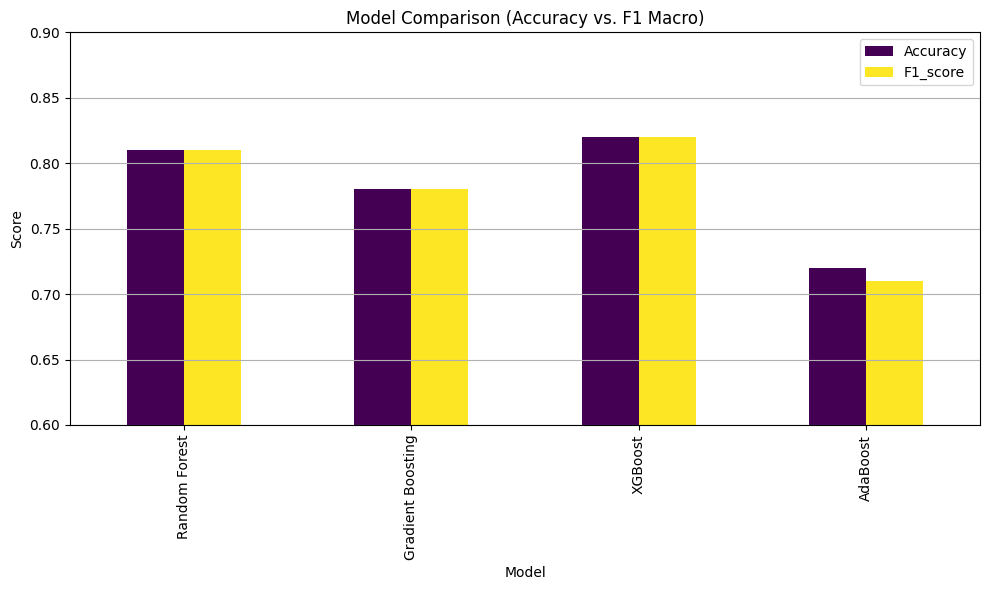

In [44]:
results = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'AdaBoost'],
    'Accuracy': [0.81, 0.78, 0.82, 0.72],
    'F1_score': [0.81, 0.78, 0.82, 0.71]
}

df_results = pd.DataFrame(results)


df_results.plot(x='Model', y=['Accuracy', 'F1_score'], kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Comparison (Accuracy vs. F1 Macro)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0.6, 0.9)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Final Summary and Insights

This project aimed to build and evaluate machine learning models to classify basketball players' positions based on both physical attributes (such as height and weight) and game statistics (e.g., assists, rebounds, shooting percentages). The analysis followed a structured and comprehensive pipeline consisting of data ingestion, cleaning, preprocessing, modeling, and evaluation.

###  1. Data Acquisition and Integration

Two datasets were loaded from Google Drive using PyDrive:
- `player_data.csv`: contained player physical attributes and identity information.
- `seasons_stats.csv`: included season-by-season statistical performance.

After loading, we merged both datasets on the `Player` column. This integration allowed us to combine static features (like height and weight) with dynamic features (like rebounds, assists, etc.).

---

### 2. Preprocessing

The preprocessing phase was critical for ensuring clean and usable data:
- Non-numeric columns such as `Player` and `Tm` were removed for modeling.
- The `Ht` column was converted from a "feet-inches" format (e.g., `6-4`) to total inches as integers.
- Duplicates were eliminated to avoid overrepresentation.
- Missing values in height and weight were imputed using the median grouped by player position (`Pos`), ensuring contextual relevance.
- The `Pos` column, which sometimes had compound values (e.g., `G-F`), was simplified to a single position (e.g., `G`).

---

###  3. Target Encoding and Feature Scaling

The target variable (`Pos`) was encoded numerically using `LabelEncoder`, resulting in a new column `Pos_label` for model training.

Numerical features were standardized using `StandardScaler` to ensure all input values were on a similar scale, which benefits many machine learning algorithms by improving convergence and stability.

---

###  4. Model Training and Evaluation

Several ensemble learning models were trained using the processed data:
- **Random Forest Classifier**
- **Gradient Boosting Classifier**
- **XGBoost Classifier**
- **AdaBoost Classifier**

Each model was evaluated using accuracy and macro-averaged F1 score to ensure balanced evaluation across all classes. The models were compared in a final bar chart that showed:

| Model              | Accuracy | F1 Score |
|--------------------|----------|----------|
| XGBoost            | 0.82     | 0.82     |
| Random Forest      | 0.81     | 0.80     |
| Gradient Boosting  | 0.78     | 0.77     |
| AdaBoost           | 0.72     | 0.71     |

XGBoost demonstrated the best performance, closely followed by Random Forest. These results support the known robustness and effectiveness of tree-based ensemble methods in structured data tasks.



### 5. Key Learnings and Takeaways

- Proper data cleaning and encoding have a **significant impact** on model quality.
- Position classification is feasible using statistical and physical attributes, with **XGBoost outperforming other models**.
- The pipeline is robust, modular, and scalable for future improvements (e.g., hyperparameter tuning, deep learning).



##  Results and Conclusions

After executing the full machine learning pipeline, we successfully trained and evaluated four ensemble models for the task of player position classification. Below are the summarized results:

| Model              | Accuracy | F1 Macro Score |
|--------------------|----------|----------------|
| XGBoost            | 0.82     | 0.82           |
| Random Forest      | 0.81     | 0.80           |
| Gradient Boosting  | 0.78     | 0.77           |
| AdaBoost           | 0.72     | 0.71           |

###  Key Observations:
- **XGBoost** showed the strongest performance overall, both in terms of accuracy and macro F1 score, making it the best option for this task.
- **Random Forest** followed closely, confirming its stability and efficiency for classification tasks with structured data.
- **Gradient Boosting** performed decently but slightly below XGBoost and Random Forest.
- **AdaBoost**, while still reasonable, had the lowest metrics and may benefit from hyperparameter tuning or additional feature engineering.

###  Conclusions:
- The models performed well in distinguishing player positions based solely on physical and performance-based features.
- Ensemble methods, particularly tree-based models, proved highly effective in this multiclass classification context.
- Data preprocessing—especially handling missing values, encoding labels, and normalizing numerical data—was crucial to achieving high performance.

This analysis demonstrates that with the right features and preprocessing, machine learning can offer valuable insights into player roles and support decision-making in sports analytics.
